In [1]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
import xml.etree.ElementTree as ET

In [2]:
resnet = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights=torchvision.models.detection.FasterRCNN_ResNet50_FPN_V2_Weights.COCO_V1)

In [3]:
resnet.roi_heads.box_predictor.cls_score = torch.nn.Linear(1024,37)

In [4]:
resnet.train()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [5]:
my_gpu = torch.device(0)

In [6]:
resnet.to(my_gpu)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [10]:
def collate_fn(batch):
    # Create stacked image tensor
    images_tensor = torch.Tensor(len(batch),batch[0][0].shape[0],batch[0][0].shape[1],batch[0][0].shape[2])
    # Create list of dicts for target
    target = []
    # Populate stacked image tensor
    for img_idx in range(len(batch)):
        images_tensor[img_idx,:,:,:] = batch[img_idx][0]
        target.append(batch[img_idx][1])
    return images_tensor, target

In [11]:
img_transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),torchvision.transforms.Normalize(mean=[.5,.5,.5],std=[.5,.5,.5])])
trainset = datasets.oxford_iiit_pet.OxfordIIITPet('G:/datasets/',transform=img_transform,target_types="detection")#,target_transform=target_transform)
#testset = datasets.oxford_iiit_pet.OxfordIIITPet('G:/datasets/',split='test',transform=img_transform)#,target_transform=target_transform)
trainloader = DataLoader(trainset,batch_size=1,shuffle=True,collate_fn=collate_fn)
#testloader = DataLoader(testset,batch_size=1)
optim = torch.optim.SGD(resnet.parameters(),lr=.01)
clsloss = torch.nn.CrossEntropyLoss()
boxloss = torch.nn.SmoothL1Loss()

Dataset does not contain detection annotations for every sample. Filtering to includeonly those that do.


In [ ]:
loss_total = 0
step_total = 0
for epoch in range(10):
    for img,target in trainloader:
        img = img.to(my_gpu)
        for tar in target:
            tar['boxes'] = tar['boxes'].to(my_gpu)
            tar['labels'] = tar['labels'].to(my_gpu)
        optim.zero_grad()
        output = resnet(img,target)
        losses = sum(loss for loss in output.values())
        losses.backward()
        optim.step()
        losses.detach()
        torch.cuda.empty_cache()
        ld = losses.cpu().item()
        loss_total += ld
        step_total += 1
        if step_total % 100 == 0:
            print(loss_total/step_total)
            loss_total = 0
            step_total = 0

0.337317331507802
0.2444331380724907
0.2362205614335835
0.23854784987866878
0.21806340493261814
0.24469375886023045
0.24869478479027748
0.2305536898970604
0.2246744890511036
0.2219043225608766
0.2385990311205387
0.2301737517490983
0.22571100594475865
0.22786114778369665
0.22340229419991375
0.22999295279383658
0.21196379324421286
0.21386607270687819
0.2052688867226243
0.21825659818947316
0.2067867653258145
0.20751551585271955
0.19872569983825086
0.2171891226992011
0.2137298060208559
0.2137514518201351
0.21529133848845958
0.19816252689808608
0.202514561470598
0.2022700173035264
0.18879537183791398
0.19377005342394113
0.18855598781257868
0.19192805144935846
0.18044887237250806
0.18788150329142808
0.18931215558201075
0.1662791410461068
0.17439174277707933
0.1699195120483637
0.16393335163593292
0.15539491770789027
0.16194886956363916
0.15840515699237584
0.15377464447170497
0.15926741264760494
0.15524367339909076
0.15102201744914054
0.1488543701544404
0.15053123120218515
0.1498798130080104
0

In [45]:
x = img.detach().cpu().numpy().squeeze(axis=0)

In [46]:
import numpy as np
x = np.moveaxis(x,0,-1)

In [29]:
import matplotlib.pyplot as plt
import cv2

In [28]:
outdict

[{'boxes': tensor([[ 73.9994,  25.2703, 171.0898, 130.2941]], device='cuda:0',
         grad_fn=<StackBackward0>),
  'labels': tensor([1], device='cuda:0'),
  'scores': tensor([0.9994], device='cuda:0', grad_fn=<IndexBackward0>)}]

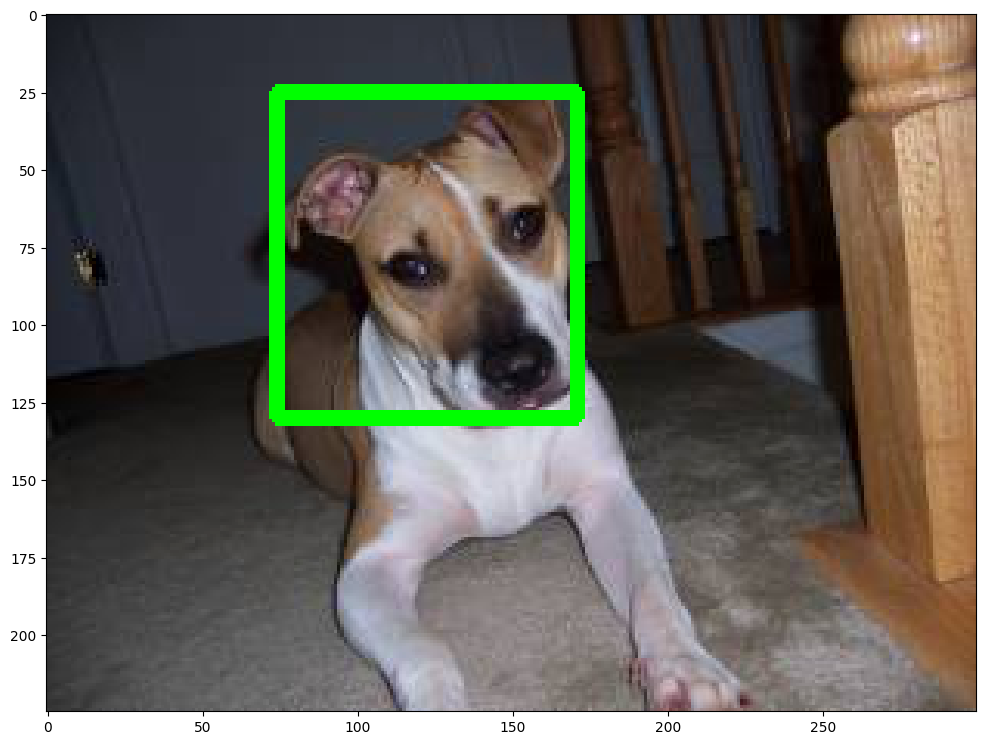

In [47]:
fig = plt.figure(figsize=(12,12))
#plt.imshow(x)
xmin = outdict[0]['boxes'][0,0].detach().cpu().item()
ymin = outdict[0]['boxes'][0,1].detach().cpu().item()
xmax = outdict[0]['boxes'][0,2].detach().cpu().item()
ymax = outdict[0]['boxes'][0,3].detach().cpu().item()
x = cv2.rectangle(cv2.UMat((x+1)/2),(int(round(xmin)),int(round(ymin))),(int(round(xmax)),int(round(ymax))),(0.,1.,0.),3)
plt.imshow(x.get())
plt.show()

In [42]:
np.min(x.get())

-1.0